In [13]:
# imports

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

In [14]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from collections import Counter

In [15]:
import json

In [16]:
# Turn off warnings
import warnings

warnings.filterwarnings('ignore')

## Preprocessing

In [17]:
# loading the two datasets 

ratings_ba_df = pd.read_csv('data/BeerAdvocate/ratings_BA.csv')
ratings_rb_df = pd.read_csv('data/RateBeer/ratings_RB.csv')


# loading the users dataset 

users_ba_df = pd.read_csv('data/BeerAdvocate/users.csv')
users_rb_df = pd.read_csv('data/RateBeer/users.csv')

# loading the beers dataset

beers_ba_df = pd.read_csv('data/BeerAdvocate/beers.csv')
beers_rb_df = pd.read_csv('data/RateBeer/beers.csv')

In [18]:
# Convert the date column to datetime format for BeerAdvocate
ratings_ba_df['date'] = pd.to_datetime(ratings_ba_df['date'], unit='s')
ratings_ba_df['year'] = ratings_ba_df['date'].dt.year
ratings_ba_df['month'] = ratings_ba_df['date'].dt.month

# Convert the date column to datetime format for RateBeer
ratings_rb_df['date'] = pd.to_datetime(ratings_rb_df['date'], unit='s')
ratings_rb_df['year'] = ratings_rb_df['date'].dt.year
ratings_rb_df['month'] = ratings_rb_df['date'].dt.month

## Filter on location

In [19]:
users_rb_df['location'] = users_rb_df['location'].str.split(',').str[0]
users_ba_df['location'] = users_ba_df['location'].str.split(',').str[0]

US_country = 'United States'

# keep only the rows where the user country is United States
users_ba_df = users_ba_df[users_ba_df.location == US_country]
users_rb_df = users_rb_df[users_rb_df.location == US_country]

# merge the ratings and users data frames to get the location of the user for each rating
ratings_users_ba_df = pd.merge(ratings_ba_df, users_ba_df[['user_id', 'location']], on='user_id', how='inner')
ratings_users_rb_df = pd.merge(ratings_rb_df, users_rb_df[['user_id', 'location']], on='user_id', how='inner')

# filter the ratings dataframes to only keep the popular ratings of the users from the US
ratings_ba_df = ratings_users_ba_df[ratings_users_ba_df.location == US_country]
ratings_ba_df.drop('location', axis=1, inplace=True)
ratings_rb_df = ratings_users_rb_df[ratings_users_rb_df.location == US_country]
ratings_rb_df.drop('location', axis=1, inplace=True)

## Separate the good ratings and bad ratings

In [20]:
mean_ba = ratings_ba_df.rating.mean()
mean_rb = ratings_rb_df.rating.mean()

print("Mean rating in BeerAdvocate:", mean_ba)
print("Mean rating in RateBeer:", mean_rb)

Mean rating in BeerAdvocate: 3.846906563579535
Mean rating in RateBeer: 3.3793541115704993


In [21]:
ratings_ba_df_untouched = ratings_ba_df.copy()
ratings_rb_df_untouched = ratings_rb_df.copy()

# Filter the ratings dataframes to only keep the popular ratings
good_ratings_ba_df = ratings_ba_df[ratings_ba_df['rating'] > mean_ba]
good_ratings_rb_df = ratings_rb_df[ratings_rb_df['rating'] > mean_rb]

bad_ratings_ba_df = ratings_ba_df[ratings_ba_df['rating'] <= mean_ba]
bad_ratings_rb_df = ratings_rb_df[ratings_rb_df['rating'] <= mean_rb]

In [22]:
# merge the two ratings data frames
good_ratings_combined_df = pd.concat([good_ratings_ba_df, good_ratings_rb_df], ignore_index=True)
bad_ratings_combined_df = pd.concat([bad_ratings_ba_df, bad_ratings_rb_df], ignore_index=True)

combinde_ratings_df = pd.concat([ratings_ba_df_untouched, ratings_rb_df_untouched], ignore_index=True)

In [23]:
bad_ratings_combined_df

,beer_name,beer_id,brewery_id,brewery_name,style,date,user_id,user_name,appearance,aroma,palate,taste,overall,rating,text,year,month
0,Régab,142544,37262,Societe des Brasseries du Gabon (SOBRAGA),Euro Pale Lager,2015-08-20 10:00:00,nmann08.184925,nmann08,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",2015,8
1,Americano Imperial Coffee IPA,131646,31221,Siren Craft Brew,English India Pale Ale (IPA),2014-08-29 10:00:00,nmann08.184925,nmann08,NaN,NaN,NaN,NaN,NaN,3.50,"On draft, pours a dark brown with red hues, wi...",2014,8
2,Maiden 2013,127138,31221,Siren Craft Brew,English Barleywine,2014-08-29 10:00:00,nmann08.184925,nmann08,NaN,NaN,NaN,NaN,NaN,3.75,"On draft, pours a translucent but very dark re...",2014,8
3,Siren / Evil Twin The Flying Dutchman,120799,31221,Siren Craft Brew,English Pale Ale,2014-08-29 10:00:00,nmann08.184925,nmann08,NaN,NaN,NaN,NaN,NaN,3.25,"On draft, pours a hazy pale yellow, very froth...",2014,8
4,Siren / To Øl 10 Finger Discount,133715,31221,Siren Craft Brew,American IPA,2014-08-29 10:00:00,nmann08.184925,nmann08,NaN,NaN,NaN,NaN,NaN,3.75,"On draft, pours a slightly hazy pale orange, w...",2014,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233656,Belzebuth 13°,4489,759,Grain dOrge (Brasseurs De Gayant),Belgian Strong Ale,2012-07-27 10:00:00,198985,iwedyou,4.00,3.00,5.00,8.00,9.0,2.90,Very mild taste for a high alcohol content. I ...,2012,7
2233657,Singha,1092,178,Boon Rawd Brewery,Premium Lager,2007-02-22 11:00:00,50256,jlelandg,4.00,4.00,4.00,3.00,13.0,2.80,Tasty! Really good fresh on a hot day in Bang...,2007,2
2233658,Singha,1092,178,Boon Rawd Brewery,Premium Lager,2012-11-20 11:00:00,225272,tsbullock89,3.00,2.00,5.00,8.00,10.0,2.80,"Good taste, no smell really, bottle design not...",2012,11
2233659,Holland Beer Dunkel,86571,9468,Holland Beer,Schwarzbier,2008-04-20 10:00:00,72689,microlover,3.00,3.00,4.00,7.00,15.0,3.20,"south-german Dunkel, could be a bit more tasty...",2008,4


## How to consider the most popular beer for each category ? 

In [24]:
# group by beer_id and compute the average aroma and the number of ratings for each beer
beer_rating_df = combinde_ratings_df.groupby('beer_id').agg({'rating': 'mean', 'beer_id': 'count'})
beer_rating_df.rename(columns={'beer_id': 'count'}, inplace=True)
beer_rating_df.reset_index(inplace=True)

beer_rating_df.sort_values(by=['count', 'rating'], ascending=False, inplace=True)
beer_rating_df

,beer_id,rating,count
665,680,4.131435,5497
1048,1093,4.027117,4551
402,412,3.790415,4168
1049,1094,3.856541,3854
2001,2093,4.233636,3727
...,...,...,...
226319,326701,0.500000,1
277088,452975,0.500000,1
277097,453009,0.500000,1
277102,453017,0.500000,1


The problem here is, what should we consider as popular? 
If we consider only the average rating, we could have a beer with a rating of 10 but with only 1 review. This does not represent the popularity we are looking for. 

Let's display a similar dataframe for the rating of each attribute: taste, appearance, aroma and palate.

In [25]:
def get_best_beers(df, attribute, n=10):
    """Return the n best beers from the dataframe"""
    beer_rating_df = df.groupby('beer_id').agg({attribute: 'mean', 'beer_id': 'count'})
    beer_rating_df.rename(columns={'beer_id': 'count'}, inplace=True)
    beer_rating_df.reset_index(inplace=True)

    beer_rating_df.sort_values(by=['count', attribute], ascending=False, inplace=True)
    
    # print the 10 best beers ids
    print(beer_rating_df.head(n))

We observe that the top 10 beers are the same throughout the categories, because the count of the reviews is preferred over the average rating, eventhough we observe different average rating from the different attributes. Thus, the sorting should be more balanced between the number of ratings and the average rating.

To correctly rank the beers, we will consider the lower bound of Wilson score. 
Wilson lower bound score presents the usefulness value of a product/comment to the user with a 95% confidence interval (https://medium.com/@okanckaya/rating-products-sorting-reviews-aff32cbd29c1).

Here we will consider as negative ratings (i.e bad ratings) the number of ratings that are below the average rating. And we will consider as positive rating (i.e. good rating) the number of ratings that are above the average. 

In [26]:
import math
import scipy.stats as st

def wilson_lower_bound (pos, neg, confidence=0.95):
    n = pos + neg
    if n == 0:
        return 0
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    phat = 1.0 * pos / n
    return (phat + z * z / (2 * n) - z * math. sqrt ((phat * (1 - phat) + z * z / (4 * n)) / n)) / (1 + z * z / n)

Let's rank the beers by computing the Wilson lower bound for each beer. 

In [27]:
# print the average rating for the dataframe 
average_rating = combinde_ratings_df['rating'].mean()
print("Average rating:", average_rating)

Average rating: 3.5804573424896784


In [28]:
beer_rating_df = combinde_ratings_df.copy()

beer_rating_df['above_average'] = beer_rating_df['rating'] > average_rating
beer_rating_df['below_average'] = beer_rating_df['rating'] <= average_rating

# group by beer_id and compute the average rating and the number of ratings for each beer
beer_rating_df = beer_rating_df.groupby('beer_id').agg({'rating': 'mean', 'beer_id': 'count', 'above_average': 'sum', 'below_average': 'sum'})
beer_rating_df.rename(columns={'rating': 'average_rating', 'beer_id': 'count'}, inplace=True)
beer_rating_df.reset_index(inplace=True)

# compute the lower bound for the average rating
beer_rating_df['lower_bound'] = beer_rating_df.apply(lambda row: wilson_lower_bound(row['above_average'], row['below_average']), axis=1)

# sort the dataframe by the lower bound
beer_rating_df.sort_values(by='lower_bound', ascending=False, inplace=True)

# print the 10 best beers ids
print(beer_rating_df.head(10))

       beer_id  average_rating  count  above_average  below_average  \
74811    86237        4.685437    664            661              3   
19626    21690        4.690985    934            928              6   
97243   115317        4.689776    312            311              1   
50780    58299        4.579204    377            375              2   
7461      7971        4.598017   3662           3604             58   
54187    62397        4.675419    334            332              2   
1484      1545        4.628038   1626           1602             24   
32643    37265        4.495938    650            643              7   
98246   116684        4.435559    322            320              2   
68899    79387        4.501307    153            153              0   

       lower_bound  
74811     0.986801  
19626     0.986056  
97243     0.982071  
50780     0.980866  
7461      0.979581  
54187     0.978433  
1484      0.978131  
32643     0.977939  
98246     0.977640  
68899   

In [29]:
# print the name of the beer with the highest lower bound of the confidence interval
beer_id = beer_rating_df.iloc[0]['beer_id']
beer_name = combinde_ratings_df[combinde_ratings_df['beer_id'] == beer_id].iloc[0]['beer_name']
print("The beer with the highest lower bound of the confidence interval is:", beer_name)

The beer with the highest lower bound of the confidence interval is: Julius


We clearly observe that the ranking is not the same as initially done.

Let's create a function that we will use to find out the most popular beer for a rating. 

In [30]:
def get_wilson_beers(df, attribute, n=10, bad=False, group='beer_id'):
    # bad is a boolean to decide whether we want the bad ratings.
    average_rating = df[attribute].mean()
    
    beer_rating_df = df.copy()

    beer_rating_df['above_average'] = beer_rating_df[attribute] > average_rating
    beer_rating_df['below_average'] = beer_rating_df[attribute] <= average_rating

    beer_rating_df = beer_rating_df.groupby(group).agg({attribute: 'mean', 'beer_id': 'count', 'above_average': 'sum', 'below_average': 'sum'})
    beer_rating_df.rename(columns={group: 'count'}, inplace=True)
    beer_rating_df.reset_index(inplace=True)
    
    # compute the lower bound of the confidence interval for each beer
    beer_rating_df['lower_bound'] = beer_rating_df.apply(lambda row: wilson_lower_bound(row['above_average'], row['below_average']), axis=1)
    
    # sort by the lower bound of the confidence interval
    beer_rating_df.sort_values(by=['lower_bound'], ascending=bad, inplace=True)
    
    # select the top n beers
    beer_rating_df = beer_rating_df.head(n)
    
    print(beer_rating_df)
    
    return beer_rating_df.beer_id.values

Let's observe the ranking of the beers by sorting the ratings by the lower bound of Wilson. 

In [31]:
# for taste
print("Best beers for taste:")
taste_beer_ids = get_wilson_beers(combinde_ratings_df, 'taste', n=10)

# for aroma
print("Best beers for aroma:")
aroma_beer_ids = get_wilson_beers(combinde_ratings_df, 'aroma', n=10)

# for appearance
print("Best beers for appearance:")
appearance_beer_ids = get_wilson_beers(combinde_ratings_df, 'appearance', n=10)

# for palate
print("Best beers for palate:")
palate_beer_ids = get_wilson_beers(combinde_ratings_df, 'palate', n=10)


Best beers for taste:
        beer_id     taste  count  above_average  below_average  lower_bound
92879    109078  7.661069    655            654              1     0.991403
108150   131594  7.911765    306            306              0     0.987602
4627       4934  8.952813   1653           1639             14     0.985834
129863   165181  8.178707    263            263              0     0.985604
90597    105767  8.351706    381            380              1     0.985285
101955   122097  8.396825    252            252              0     0.984985
57170     65881  8.119417   1030           1022              8     0.984749
13091     14232  8.563501   1874           1855             19     0.984219
50580     58057  8.937778    225            225              0     0.983213
57808     66624  8.227931    759            753              6     0.982862
Best beers for aroma:
        beer_id     aroma  count  above_average  below_average  lower_bound
53227     61167  8.028953    449            

## Attribute analysis

In [32]:
# drop rows where there are null values for taste, aroma, appearance, palate
combinde_ratings_df.dropna(inplace=True)

In [33]:
# Calculate correlation coefficients
correlation_matrix = combinde_ratings_df[['rating', 'taste', 'aroma', 'appearance', 'palate']].corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Extract correlations with overall rating
overall_correlations = correlation_matrix['rating'].drop('rating')

# Print correlations with overall rating
print("\nCorrelations with Overall Rating:")
print(overall_correlations)

# Identify which attribute has the highest correlation
max_corr_attribute = overall_correlations.idxmax()
print("\nThe attribute with the highest correlation with Overall Rating:", max_corr_attribute)


Correlation Matrix:
              rating     taste     aroma  appearance    palate
rating      1.000000  0.313639  0.274070    0.661040  0.790602
taste       0.313639  1.000000  0.896132    0.135081  0.208878
aroma       0.274070  0.896132  1.000000    0.132816  0.145018
appearance  0.661040  0.135081  0.132816    1.000000  0.593588
palate      0.790602  0.208878  0.145018    0.593588  1.000000

Correlations with Overall Rating:
taste         0.313639
aroma         0.274070
appearance    0.661040
palate        0.790602
Name: rating, dtype: float64

The attribute with the highest correlation with Overall Rating: palate


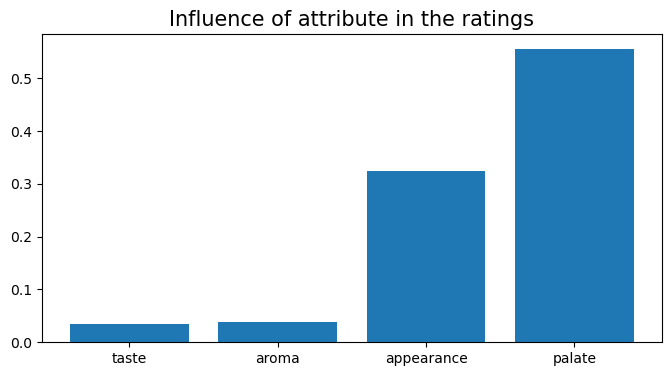

                                 OLS Regression Results                                
Dep. Variable:                 rating   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                          1.237e+08
Date:                Sat, 16 Dec 2023   Prob (F-statistic):                        0.00
Time:                        14:05:42   Log-Likelihood:                     -2.4352e+06
No. Observations:             5419565   AIC:                                  4.870e+06
Df Residuals:                 5419561   BIC:                                  4.870e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [34]:
from sklearn import linear_model
import statsmodels.api as sm

X = combinde_ratings_df[['taste', 'aroma', 'appearance', 'palate']]
y = combinde_ratings_df['rating']


clf = linear_model.LinearRegression(fit_intercept=False)
clf.fit(X, y)
weights = clf.coef_
plt.figure(figsize = (8, 4))
plt.bar(x = ['taste', 'aroma', 'appearance', 'palate'], height = weights)
plt.title('Influence of attribute in the ratings', fontsize=15)
plt.grid(False)
plt.show()

ols = sm.OLS(y, X)
model = ols.fit()

print(model.summary())

We observe that the attribute palate has the most substantial consequence on the rating, followed by appearance, aroma and taste.
Let's take a look now at the good reviews.

## Textual analysis

In [35]:
nlp = spacy.load('en_core_web_sm')

In [36]:
# drop rows where text is missing
good_ratings_combined_df.dropna(subset=['text'], inplace=True)
bad_ratings_combined_df.dropna(subset=['text'], inplace=True)
combinde_ratings_df.dropna(subset=['text'], inplace=True)

## Attribute analysis 

In [37]:
X = good_ratings_combined_df[['taste', 'aroma', 'appearance', 'palate']]
y = good_ratings_combined_df['rating']


clf = linear_model.LinearRegression(fit_intercept=False)
clf.fit(X, y)
weights = clf.coef_
plt.figure(figsize = (8, 4))
plt.bar(x = ['taste', 'aroma', 'appearance', 'palate'], height = weights)
plt.title('Influence of attribute in the good ratings', fontsize=15)
plt.grid(False)
plt.show()

ols = sm.OLS(y, X)
model = ols.fit()

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

We get the same result as before. To have more insights, let's look at the seasonality of the attributes. Do we observe any difference between the different months? 

## Attribute analysis by months

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

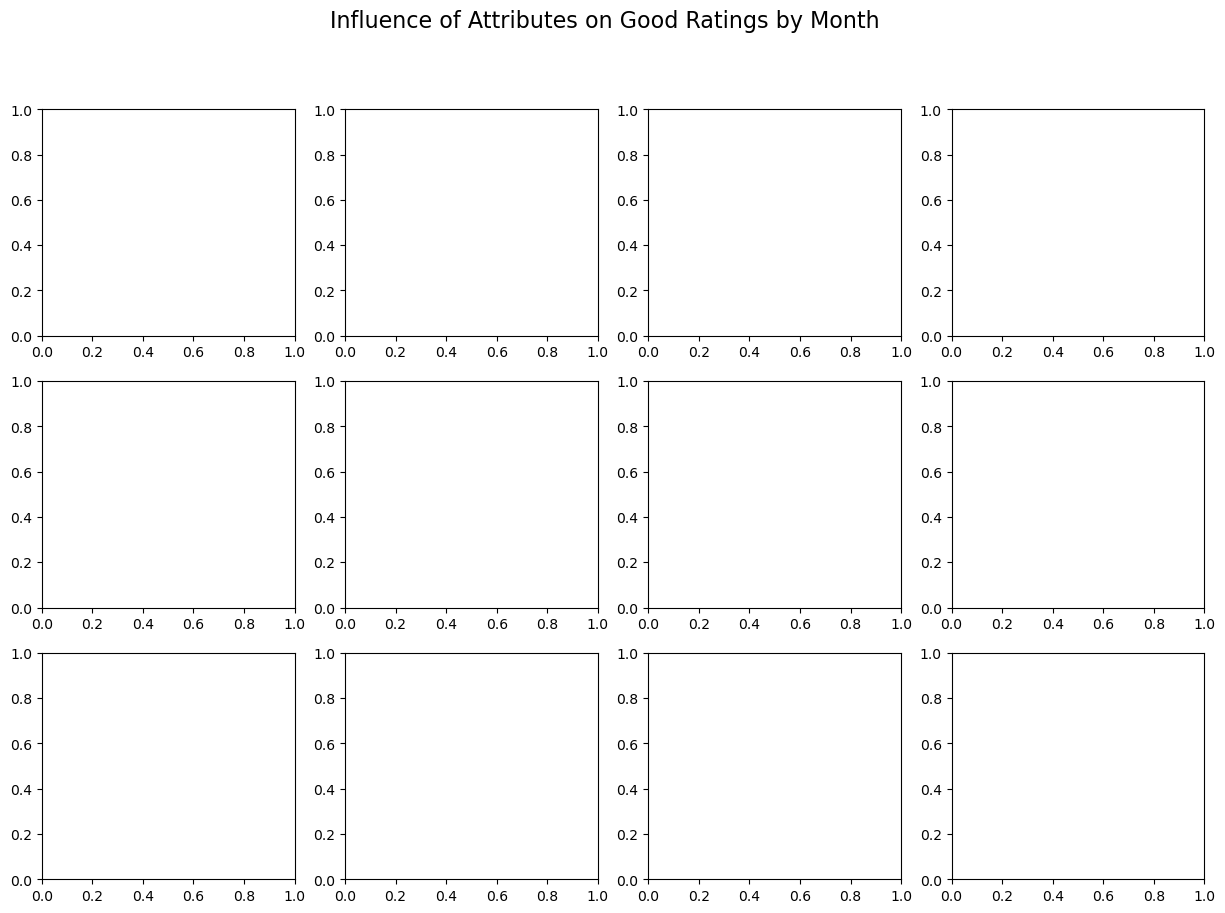

In [38]:
# List of months
months = sorted(good_ratings_combined_df['month'].unique())

# Set up subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle('Influence of Attributes on Good Ratings by Month', fontsize=16)

# Flatten the 3x4 subplot grid into a 1D array for iteration
axes = axes.flatten()

for i, month in enumerate(months):
    # Filter data for the current month
    month_df = good_ratings_combined_df[good_ratings_combined_df['month'] == month]
    
    # Define X and y for the current month
    X = month_df[['taste', 'aroma', 'appearance', 'palate']]
    y = month_df['rating']

    # Linear Regression
    clf = linear_model.LinearRegression(fit_intercept=False)
    clf.fit(X, y)
    weights = clf.coef_

    # Create a bar plot on the current subplot
    axes[i].bar(x=['taste', 'aroma', 'appearance', 'palate'], height=weights)
    axes[i].set_title(f'Month {month}')
    axes[i].set_xlabel('Attributes')
    axes[i].set_ylabel('Weights')
    axes[i].grid(False)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [39]:
# keep only the keywords that appear more than 100 times
#appearance_dict = {k: v for k, v in appearance_dict.items() if v > 100}

# list of words to remove from the dictionary
appearance_terms = ['white', 'brown', 'light', 'small', 'thin', 'dark', 'golden', 'retention', 'medium', 'hazy', 'clear', 
                            'amber', 'black', 'creamy', 'thick', 'beige', 'orange', 'yellow', 'tan', 'foamy', 'copper', 'big', 
                            'gold', 'decent', 'deep', 'cloudy', 'lace', 'moderate', 'red', 'minimal', 
                            'ring', 'bright', 'colored', 'straw', 'dense', 'reddish', 'pale', 'khaki', 
                            'slight', 'rich', 'huge', 'fizzy', 'frothy', 'solid', 'average', 
                            'short', 'bubble', 'caramel', 'soft', 'pink', 'mocha', 'opaque', 'murky', 'ruby',
                            'rocky', 'fine', 'cling', 'cap', 'mahogany', 'brownish', 'ton', 'hue',  
                            'haze', 'pitch', 'clarity', 'wispy', 'cherry', 'highlight', 'clean', 'fade', 'funky', 
                            'ivory', 'purple', 'lacy', 'bone', 'high', 'hint', 'pinkish', 'peach', 'toffee',  'yellowish', 
                            'patchy', 'bronze', 'muddy', 'firm', 'clingy', 'stringy', 'visible', 'transparent']

In [40]:
#taste_dict = {k: v for k, v in taste_dict.items() if v > 100}

taste_terms = ['sweet',  'bitter', 'smooth', 'roasted', 'dry', 'fruity', 'tart', 'bodied', 
    'bitterness', 'sour', 'strong', 'spice', 'mild', 'rich',  'yeast', 'profile', 'sweetness', 'earthy', 'balanced', 'alcohol', 
    'wheat', 'spicy', 'clean', 'moderate', 'crisp', 'grain', 'slight', 'heavy',
    'creamy', 'mid', 'complex', 'hint', 'roasty', 'bready', 'bread', 'roast', 'herbal', 'fresh', 'sugar', 'balance', 
    'solid', 'soft', 'juicy', 'subtle', 'grass', 'grassy', 'smoke',
    'funk', 'nutty', 'character', 'refreshing', 'citrusy', 'belgian', 'decent', 'bittersweet', 
    'rye', 'thick', 'thin', 'piney', 'grainy', 'clove', 'yeasty', 
    'wine', 'molasse', 'ale', 'biscuit', 'funky', 'bud', 'plenty', 'peppery', 'milk', 'barrel', 'tartness', 
    'smoky', 'woody', 'faint', 'toast', 'low', 'stout', 
    'ester', 'ton', 'bold', 'intense', 'deep', 'suit', 'brew', 'tangy', 'whiskey', 'blend', 'peel', 
    'tasty', 'ipa', 'acidic', 'straw', 'boozy', 'fruitiness', 'smokey', 'mellow', 'earthiness', 'juice', 'toasty', 'booze', 
    'average', 'tone', 'dough', 'robust', 'sourness', 'cracker', 'noticeable', 'biscuity', 
    'rind', 'barley', 'lager', 'cream', 'plum', 'acidity',  'hoppiness', 'upfront', 
    'resinous', 'syrup', 'porter', 'vinegar', 'sugary',' bubblegum']


In [41]:
#palate_dict = {k: v for k, v in palate_dict.items() if v > 100}

palate_terms = ['medium', 'light', 'smooth', 'creamy', 'dry', 'bodied', 'soft', 'thin', 'thick', 'moderate', 'crisp',  'sticky', 'slick', 
                'mid', 'solid', 'decent', 'mild', 'balanced', 'oily', 'chewy', 'deep', 'watery', 'silky', 'refreshing', 'strong', 'touch', 'balance', 'fizzy', 'character', 
                'fine', 'flat', 'full', 'hint', 'sharp', 'bready', 'foamy', 'viscous', 'chalky', 'effervescent', 'fluffy', 'grainy', 'gentle', 
                'prickly', 'tartness', 'bubbly', 'acidic', 'astringency']

In [42]:
#aroma_dict = {k: v for k, v in aroma_dict.items() if v > 100}

aroma_terms = ['citrus', 'chocolate', 'fruit', 'fruity', 'coffee',  'floral',
    'caramel', 'pine', 'grapefruit', 'tropical', 'vanilla', 'lemon', 'bourbon', 'cherry', 
    'orange', 'herbal', 'decent', 'citrusy', 'cocoa', 'honey', 'oak', 
    'toffee', 'nutty', 'banana', 'grass', 'apple', 
    'pepper', 'pineapple', 'thin', 'funk', 'clove', 'wood', 
    'berry', 'woody', 'biscuit', 'raspberry', 'grape', 'molasse', 'tangy', 'barrel', 'peach', 'raisin', 'resinous', 
    'candy', 'ipa',  'nut', 'pungent', 'pumpkin', 'ginger', 
    'mango', 'warming', 'earth', 'mellow', 'cereal', 'ring', 'astringent', 
    'coriander', 'tangerine', 'maple', 'melon', 'hay', 'lactic', 'citric', 'peel', 'rind', 'lager', 'bold', 'vinous', 'weak', 'toasted', 'blueberry', 
    'biscuity', 'spiced', 'lime', 'metallic', 'coconut', 'hay'
]

## Using the lower bound of Wilson to select the best beer

In [43]:
def matching_keywords(text, list_keywords):
    # Process the text with spaCy
    doc = nlp(text.lower())

    result = []
    for token in doc:
        token = token.lemma_
        if token in list_keywords:
            result.append(token)
    
    return result

In [44]:
def find_top_keywords_by_month(df, keywords_list, month, category, num_keywords, bad=False, group='beer_id'):
    # Filter the DataFrame for the specified month
    # bad is a boolean to determine whether we want good or bad beer.By default we consider the good beers
    
    month_df = df[df['month'] == month]

    # Find the best beer for the month based on average rating and review count
    #best_beer_df = month_df.groupby('beer_id').agg({category: ['mean', 'count']}).reset_index()
    #best_beer_df.columns = ['beer_id', 'average_rating', 'review_count']
    #beer_stats = best_beer_df.sort_values(by=['review_count', 'average_rating'], ascending=[False, False])

    # Get the beer ID of the best beer for the month
    #best_beer_id = beer_stats.iloc[0]['beer_id']
    
    beer_ids = get_wilson_beers(month_df, category, n=10, bad=bad, group=group)
    
    # print the best beer id for the month
    #print(f"Best beer for the month of {month}:", best_beer_id)

    # filter the dataframe with the 10 best/worst beers for the month
    beer_reviews = month_df[month_df['beer_id'].isin(beer_ids)]

    # Extract keywords from reviews using a matching function (e.g., matching_keywords)
    keyword_list = []
    for text in beer_reviews['text'].values.tolist():
        keyword_list.extend(matching_keywords(text, keywords_list))

    # Count the number of times each keyword appears in the reviews
    keyword_counter = Counter(keyword_list)

    # Sort the dictionary by value
    sorted_keywords = dict(sorted(keyword_counter.items(), key=lambda item: item[1], reverse=True))

    # Return the top N keywords as a list of tuples (key, value)
    top_keywords = [(key, sorted_keywords[key]) for key in list(sorted_keywords.keys())[:num_keywords]]

    return top_keywords

Creating a function to plot the distribution of keywords

In [56]:
def plot_keywords(key_words_dict, attr, bad=False):
    # Create a 3x4 grid of subplots
    fig, axes = plt.subplots(4, 3, figsize=(15, 10))
    s = 'good' if not bad else 'bad' 
    fig.suptitle(attr + ' ' + s + 'Keywords per Month', fontsize=16)

    # Flatten the 3x4 subplot grid into a 1D array for iteration
    axes = axes.flatten()

    # Iterate over each key and create a subplot
    for i, (key, data) in enumerate(key_words_dict.items()):
        keywords, values = zip(*data)

        # Create a bar plot on the current subplot
        axes[i].bar(keywords, values)
        axes[i].set_title(f'Top 10 keywords for Month {key}')
        axes[i].set_xlabel('Keywords')
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)

    # Adjust layout to prevent overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Aroma analysis 

In [45]:
# for each month, find the top 10 keywords, FOR GOOD BEERS
top_keywords_by_month = {}
for month in range(1, 13):
    top_keywords_by_month[month] = find_top_keywords_by_month(good_ratings_combined_df, aroma_terms, month, 'aroma', 10)
    #print("Month", month)
    #print(top_keywords_by_month[month])
    #print()

       beer_id     aroma  count  above_average  below_average  lower_bound
4425      8909  8.500000    266            266              0     0.985764
1733      2530  8.137795    254            254              0     0.985101
12356    42303  7.906863    204            204              0     0.981517
2811      4934  8.767442    172            172              0     0.978154
12170    41297  7.765517    145            145              0     0.974191
5124     11243  7.916667    264            262              2     0.972804
17475    64102  8.014599    137            137              0     0.972725
21478    81812  8.465385    260            258              2     0.972392
5889     14138  7.968504    127            127              0     0.970640
5072     11047  7.685039    127            127              0     0.970640
       beer_id     aroma  count  above_average  below_average  lower_bound
4293      8936  8.764045    178            177              1     0.968868
12026    43947  8.383178 

       beer_id     aroma  count  above_average  below_average  lower_bound
4317      8909  8.603960    202            200              2     0.964625
5814     14232  8.335484    155            153              2     0.954179
3913      7688  8.463636    110            109              1     0.950294
3912      7686  8.179104     67             67              0     0.945774
4326      8936  8.598425    127            125              2     0.944398
35731   187518  8.338462     65             65              0     0.944198
21948    90234  8.384615     65             65              0     0.944198
3537      6875  7.885246     61             61              0     0.940756
17166    66624  8.333333     60             60              0     0.939828
2782      4934  8.892857     84             83              1     0.935605
       beer_id     aroma  count  above_average  below_average  lower_bound
2753      4934  8.778894    199            197              2     0.964102
3880      7688  8.542553 

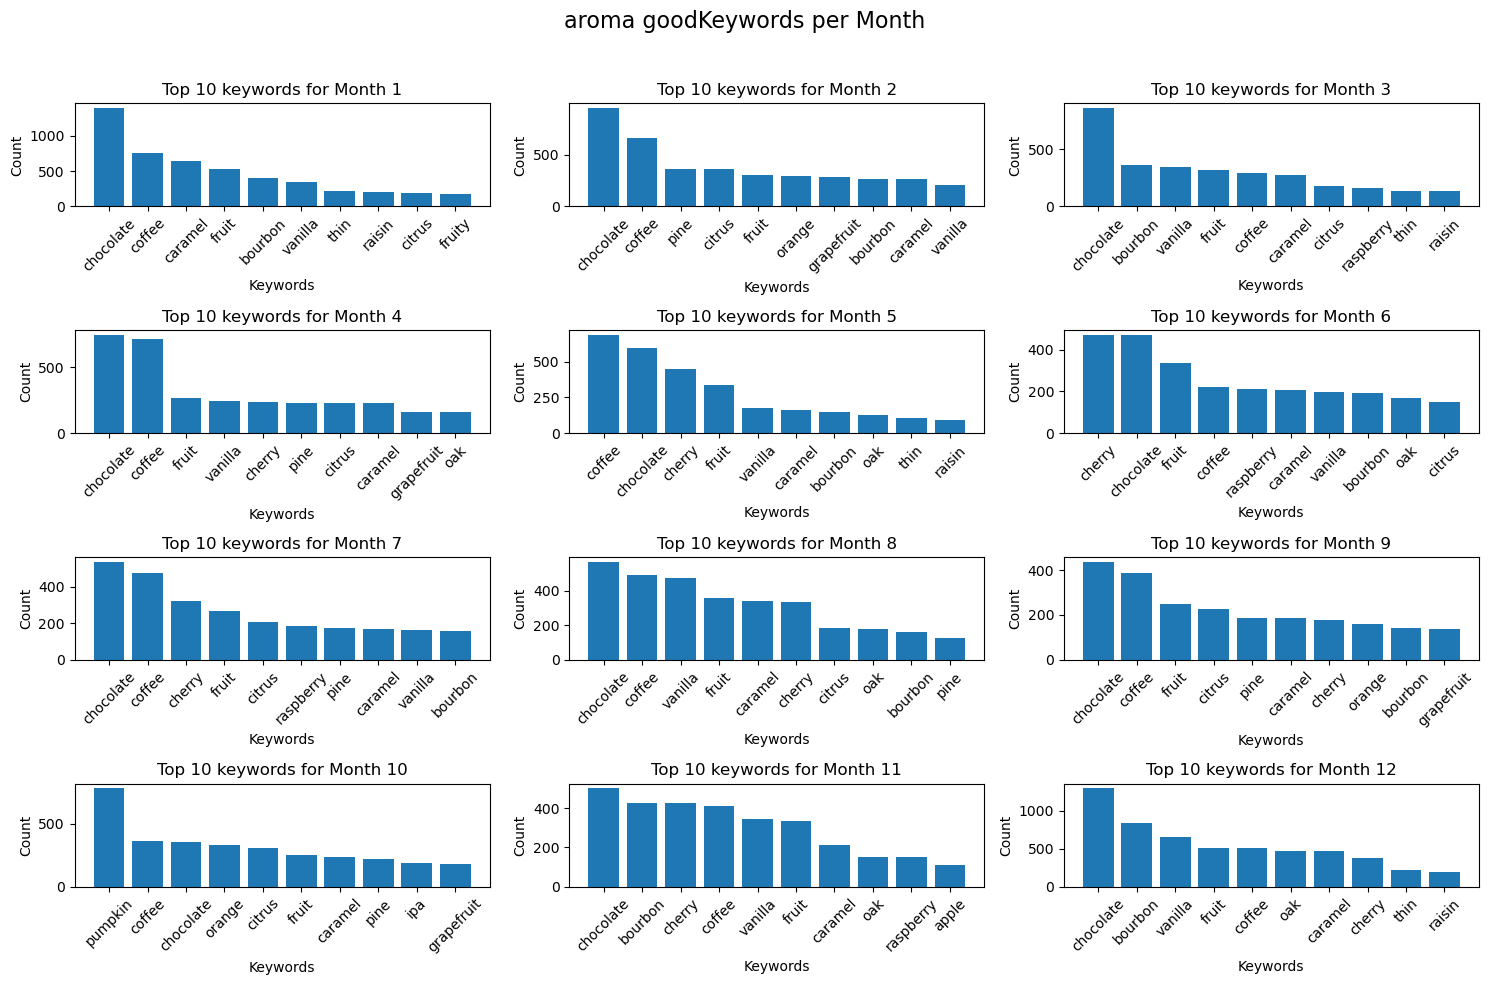

In [57]:
plot_keywords(top_keywords_by_month, 'aroma')

In [47]:
# Analysis for the bad beers
# for each bad beer, find the keywords through all the ratings, not only the bad ones.
bad_top_keywords_by_month = {}
for month in range(1, 13):
    bad_top_keywords_by_month[month] = find_top_keywords_by_month(bad_ratings_combined_df, aroma_terms, month, 'aroma', 10, True)
    #print("Month", month)
    #print(top_keywords_by_month[month])
    #print()

       beer_id     aroma  count  above_average  below_average   lower_bound
1977      2619  3.357143     21              0             21 -1.173174e-17
1040      1313  2.511905     21              0             21 -1.173174e-17
1738      2299  3.345238     21              0             21 -1.173174e-17
16810    47360  3.571429     21              0             21 -1.173174e-17
626        739  2.523810     21              0             21 -1.173174e-17
842       1002  2.988095     21              0             21 -1.173174e-17
16026    44706  3.428571     21              0             21 -1.173174e-17
23034    73139  3.285714     21              0             21 -1.173174e-17
9332     19736  3.392857     21              0             21 -1.173174e-17
9956     21619  3.476190     21              0             21 -1.173174e-17
       beer_id     aroma  count  above_average  below_average   lower_bound
10275    24651  3.214286     21              0             21 -1.173174e-17
977       12

       beer_id     aroma  count  above_average  below_average   lower_bound
19557    60642  3.357143     22              0             21 -1.173174e-17
1894      2512  3.345238     21              0             21 -1.173174e-17
27116    97291  3.273810     21              0             21 -1.173174e-17
870       1079  2.904762     21              0             21 -1.173174e-17
461        575  3.261905     21              0             21 -1.173174e-17
2906      4202  2.880952     22              0             21 -1.173174e-17
14935    41722  3.452381     21              0             21 -1.173174e-17
1150      1470  3.619048     23              0             21 -1.173174e-17
18867    57341  3.357143     21              0             21 -1.173174e-17
16086    45992  3.250000     22              0             21 -1.173174e-17
       beer_id     aroma  count  above_average  below_average   lower_bound
15920    44085  3.202381     21              0             21 -1.173174e-17
17360    492

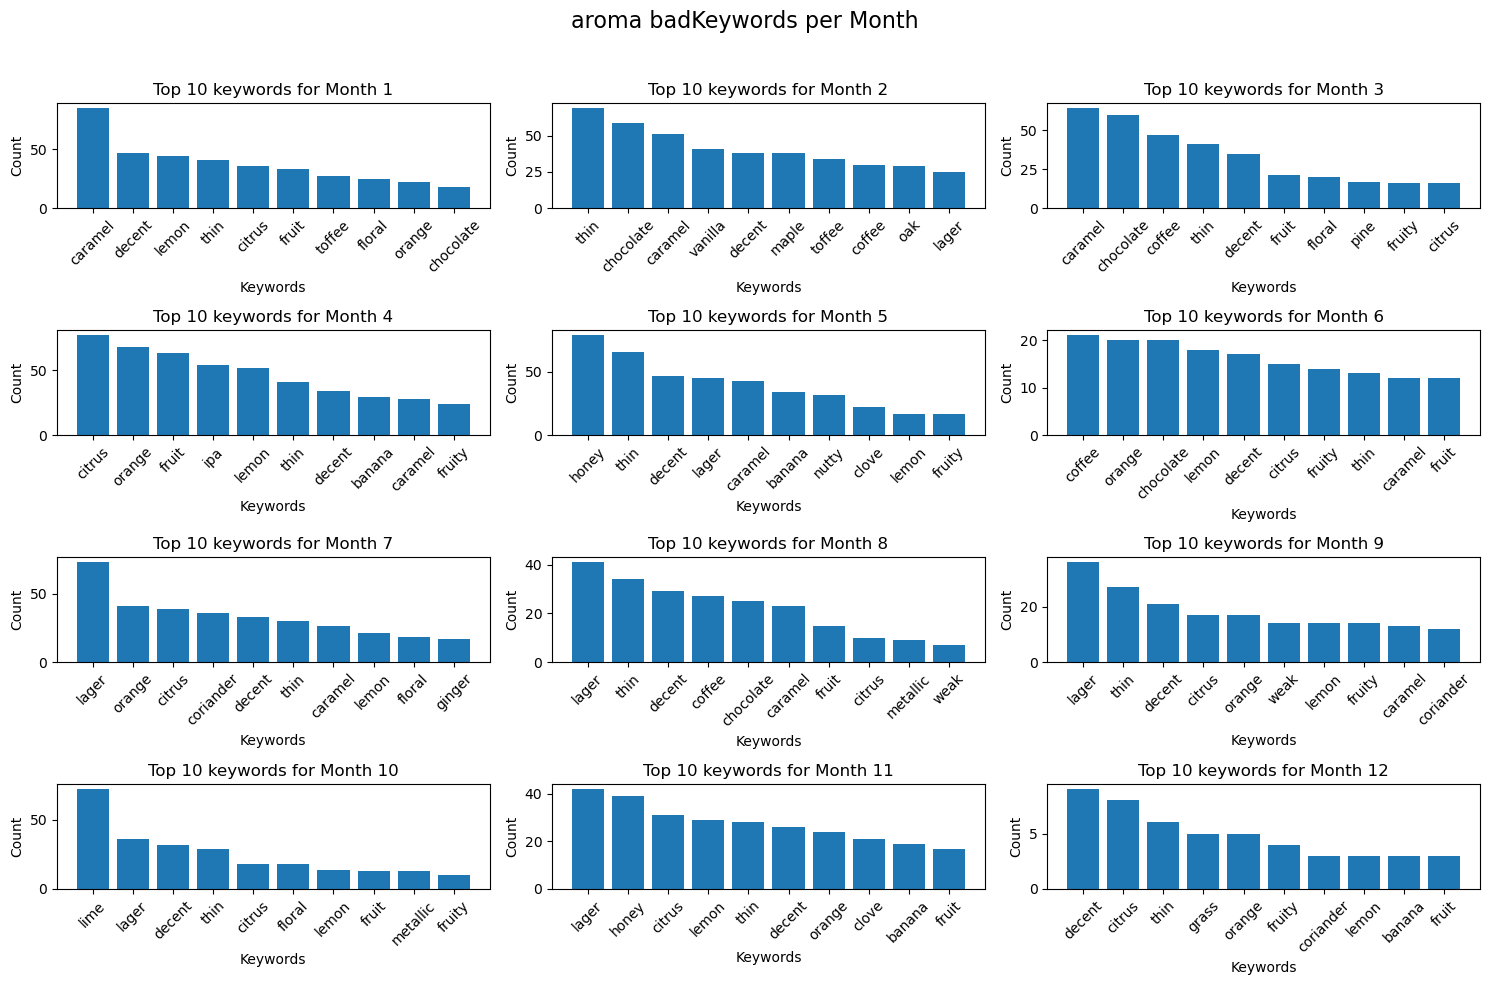

In [58]:
plot_keywords(bad_top_keywords_by_month, 'aroma', True)

In [49]:
# Analysis for the bad beers, using the style
bad_top_keywords_by_month = {}
for month in range(1, 13):
    bad_top_keywords_by_month[month] = find_top_keywords_by_month(bad_ratings_combined_df, aroma_terms, month, 'aroma', 10, True, 'style')
    #print("Month", month)
    #print(top_keywords_by_month[month])
    #print()

                              style     aroma  beer_id  above_average  \
36               Berliner Weissbier  3.322917      288              0   
106                           Kvass  3.182692       26              0   
54        Dortmunder / Export Lager  3.128019      207              0   
103             Japanese Rice Lager  2.607895       95              0   
68            English Pale Mild Ale  3.283333       45              0   
18             American Malt Liquor  2.325926      405              0   
116                Low Alcohol Beer  2.412621      103              0   
114                     Light Lager  2.112305     1280              0   
47   California Common / Steam Beer  3.227632      190              0   
74                Euro Strong Lager  2.758929      197              0   

     below_average   lower_bound  
36             288  0.000000e+00  
106             26  0.000000e+00  
54             207  0.000000e+00  
103             95  0.000000e+00  
68              45  0

                            style     aroma  beer_id  above_average  \
18           American Malt Liquor  2.387658      328              0   
66   English India Pale Ale (IPA)  3.283986      898              0   
51                 Czech Pilsener  3.234375      710              0   
35        Belgian Strong Pale Ale  3.476426      898              0   
109            Lambic - Unblended  3.536765       37              0   
41                    Black & Tan  3.092742      130              0   
104      Kellerbier / Zwickelbier  3.412371       98              0   
43                           Bock  3.084119      339              0   
103           Japanese Rice Lager  2.561404       59              0   
102                 Irish Red Ale  3.223077      468              0   

     below_average   lower_bound  
18             316 -8.569443e-19  
66             868 -4.317700e-19  
51             672 -4.312158e-19  
35             859  0.000000e+00  
109             34  0.000000e+00  
41      

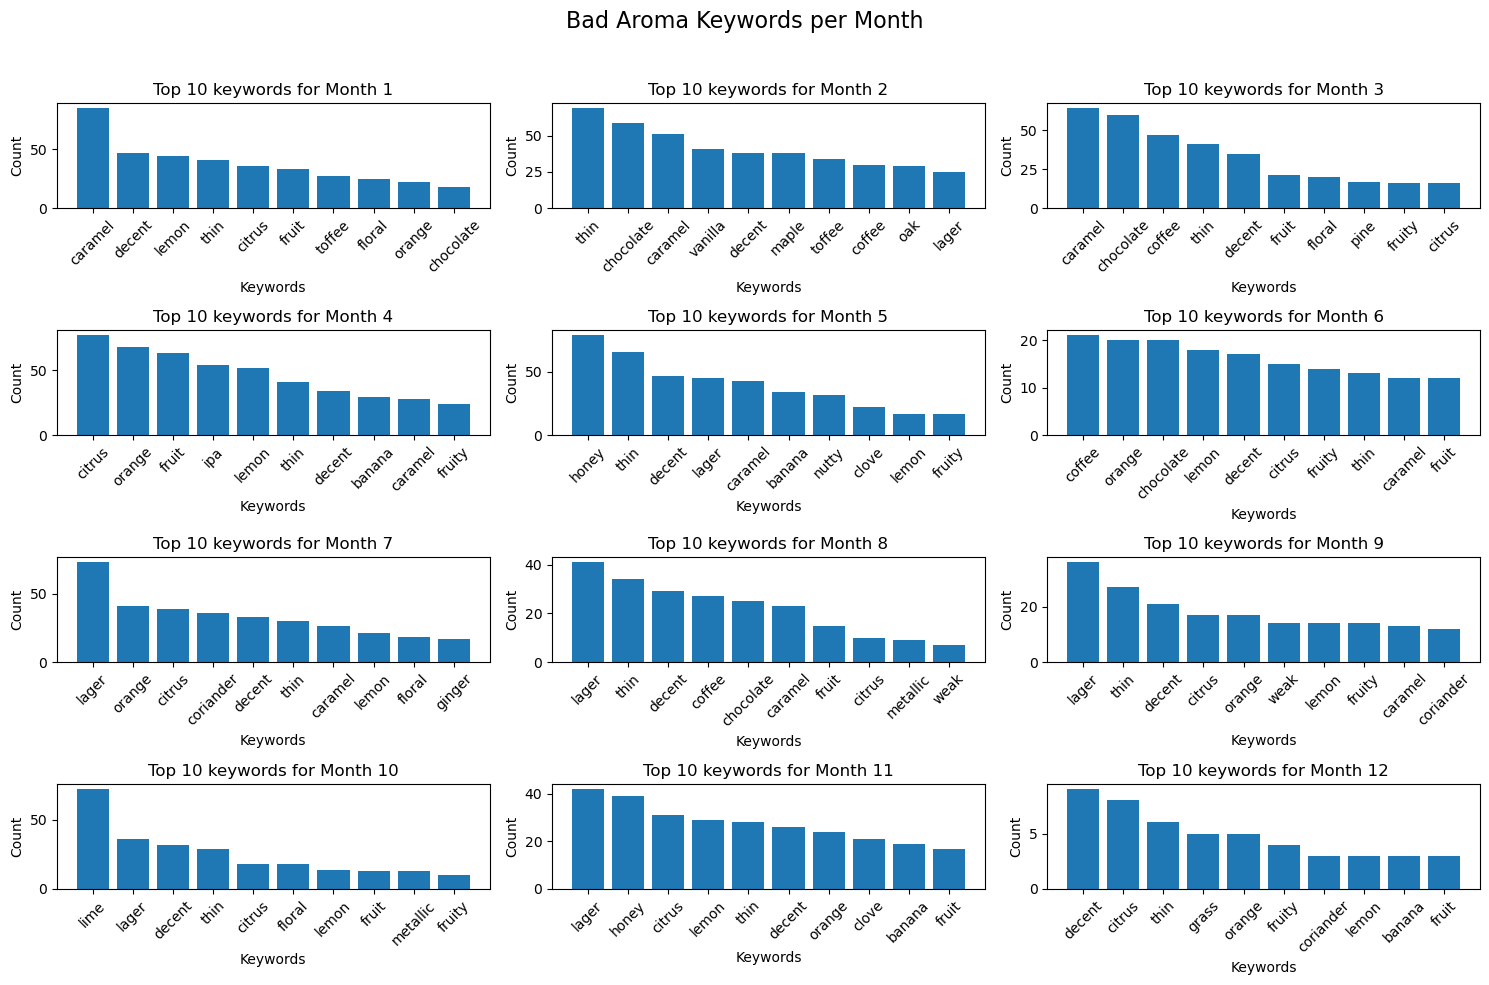

In [50]:
# Create a 3x4 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle('Bad Aroma Keywords per Month', fontsize=16)

# Flatten the 3x4 subplot grid into a 1D array for iteration
axes = axes.flatten()

# Iterate over each key and create a subplot
for i, (key, data) in enumerate(bad_top_keywords_by_month.items()):
    keywords, values = zip(*data)

    # Create a bar plot on the current subplot
    axes[i].bar(keywords, values)
    axes[i].set_title(f'Top 10 keywords for Month {key}')
    axes[i].set_xlabel('Keywords')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Taste analysis

In [51]:
# for each month, find the top 10 keywords
top_keywords_by_month_taste = {}
bad_top_keywords_by_month_taste = {}
for month in range(1, 13):
    top_keywords_by_month_taste[month] = find_top_keywords_by_month(good_ratings_combined_df, taste_terms, month, 'taste', 10)
    bad_top_keywords_by_month_taste[month] = find_top_keywords_by_month(good_ratings_combined_df, taste_terms, month, 'taste', 10, bad=True)

    #print("Month", month)
    #print(top_keywords_by_month_taste[month])
    #print()

       beer_id     taste  count  above_average  below_average  lower_bound
2811      4934  9.046512    172            172              0     0.978154
5954     14396  8.237179    156            155              1     0.964587
5190     11461  8.300971    103            103              0     0.964045
17475    64102  8.145985    137            136              1     0.959814
5099     11168  8.166667     90             90              0     0.959064
10719    34746  7.952381     84             84              0     0.956268
43509   232029  8.325301     83             83              0     0.955765
5909     14232  8.621762    193            190              3     0.955303
1701      2490  8.147541    122            121              1     0.955029
21479    81813  7.785124    121            120              1     0.954669
       beer_id     taste  count  above_average  below_average   lower_bound
30704   134356  4.464286     21              0             21 -1.173174e-17
13255    45936  4.41666

       beer_id     taste  count  above_average  below_average  lower_bound
12853    43947  8.670330     91             91              0     0.959496
6079     14396  8.192593    135            134              1     0.959236
2885      4935  8.522222     90             90              0     0.959064
4446      8936  8.707602    171            169              2     0.958364
5227     11168  8.294118     85             85              0     0.956761
13972    48429  8.166667     84             84              0     0.956268
26515   106045  8.283951     81             81              0     0.954722
16869    60246  8.486486    111            110              1     0.950727
3992      7688  8.423423    111            110              1     0.950727
11528    37835  8.652778     72             72              0     0.949349
       beer_id     taste  count  above_average  below_average   lower_bound
9914     30947  4.095238     21              0             21 -1.173174e-17
15932    57290  4.38095

       beer_id     taste  count  above_average  below_average  lower_bound
5035     11243  8.264550    378            376              2     0.980916
4317      8909  8.648515    202            199              3     0.957253
2782      4934  9.095238     84             84              0     0.956268
10685    37652  8.177419    124            123              1     0.955732
236        303  8.035088    114            113              1     0.951980
1704      2531  7.842105     76             76              0     0.951886
2991      5400  8.102941    136            134              2     0.947968
1703      2530  8.345588    136            134              2     0.947968
8186     25082  8.259542    131            129              2     0.946044
3912      7686  8.268657     67             67              0     0.945774
       beer_id     taste  count  above_average  below_average   lower_bound
35037   182398  4.369048     21              0             21 -1.173174e-17
12695    46188  4.14285

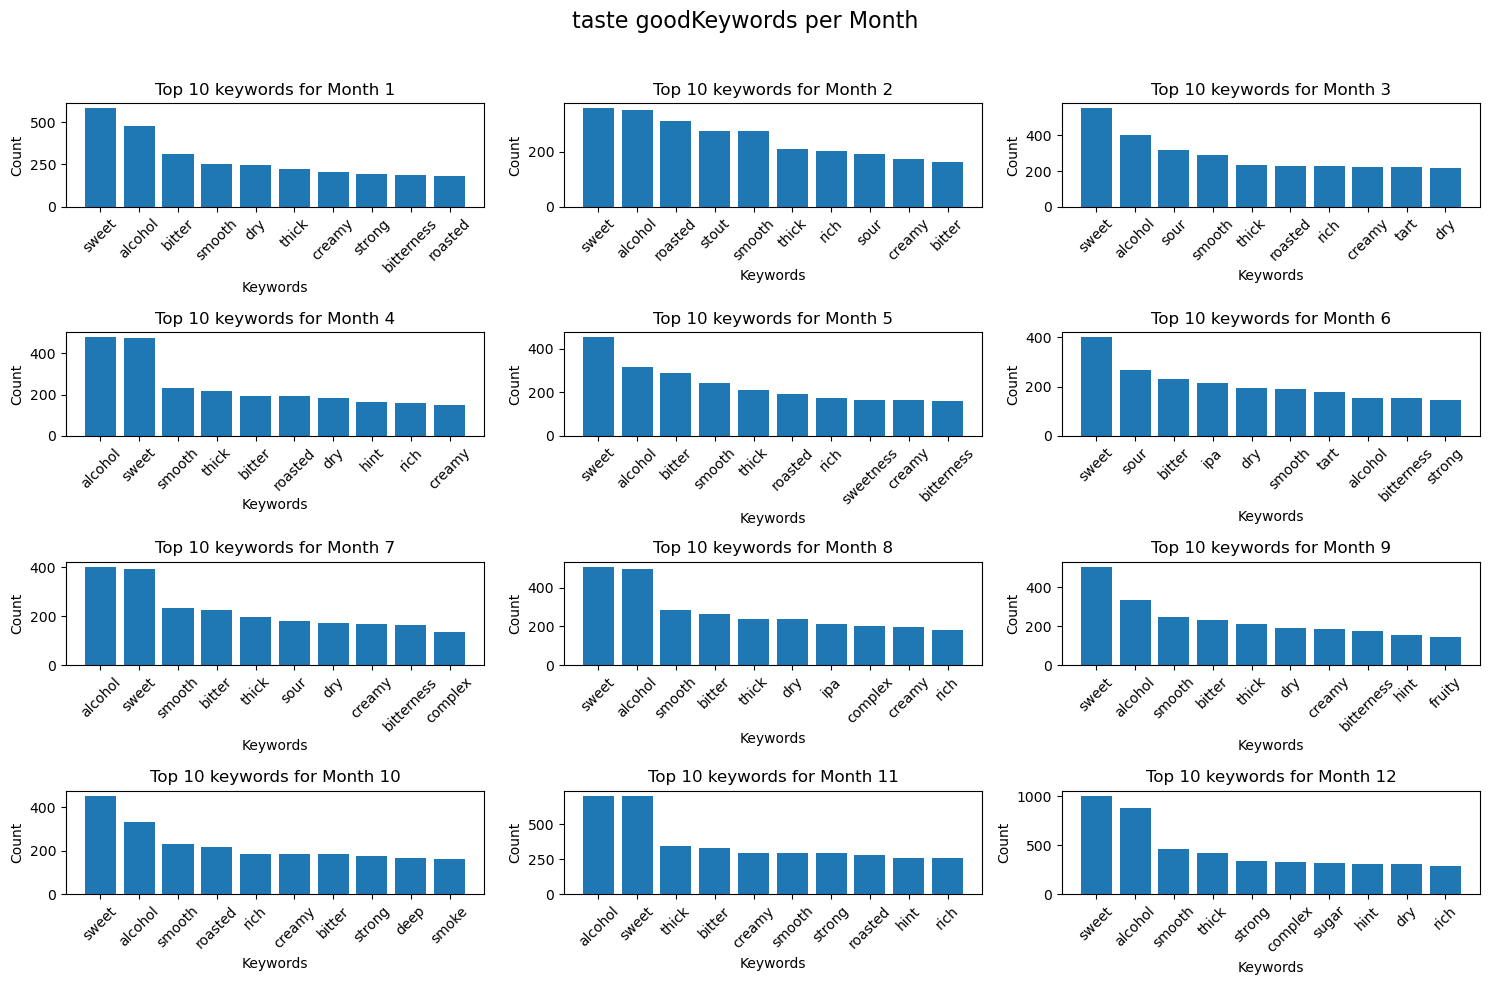

In [59]:
plot_keywords(top_keywords_by_month_taste, 'taste')

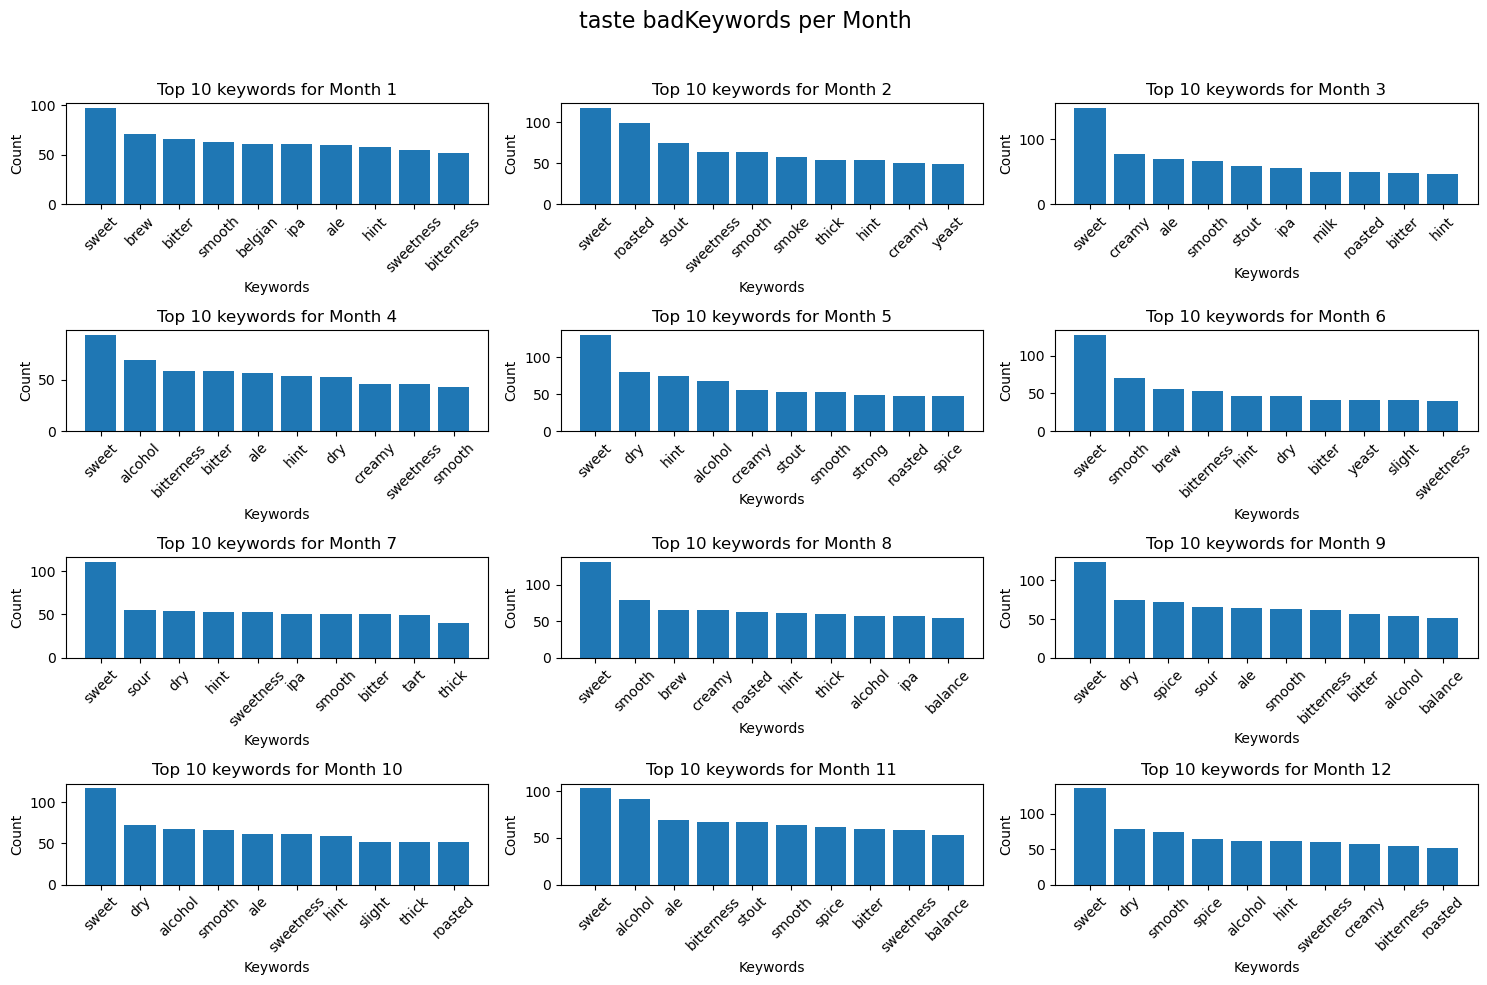

In [60]:
plot_keywords(bad_top_keywords_by_month_taste, 'taste', True)

## Palate analysis 

In [52]:
# for each month, find the top 10 keywords
top_keywords_by_month_palate = {}
bad_top_keywords_by_month_palate = {}

for month in range(1, 13):
    top_keywords_by_month_palate[month] = find_top_keywords_by_month(good_ratings_combined_df, palate_terms, month, 'palate', 10)
    bad_top_keywords_by_month_palate[month] = find_top_keywords_by_month(good_ratings_combined_df, palate_terms, month, 'palate', 10, bad=True)
  
    #print("Month", month)
    #print(top_keywords_by_month_palate[month])
    #print()

       beer_id    palate  count  above_average  below_average  lower_bound
6612     16814  4.717105    229            226              2     0.968586
882       1160  4.452247    178            176              2     0.959964
10634    34483  4.481392    311            303              6     0.958292
13875    47658  4.676357    129            128              1     0.957397
4070      7971  4.523188    345            337              8     0.954918
5260     11757  4.487222    450            438             12     0.953973
4970     10672  4.578329    383            373             10     0.952612
10613    34420  4.540698    301            293              8     0.948440
1115      1545  4.648148    162            159              3     0.946975
16913    61100  4.567164     67             67              0     0.945774
       beer_id  palate  count  above_average  below_average  lower_bound
49250   285394    3.00      1              0              1          0.0
59965   476025    3.00      1

       beer_id  palate  count  above_average  below_average  lower_bound
33780   153575    3.00      1              0              1          0.0
34994   163430    3.00      1              0              1          0.0
34989   163344    3.00      1              0              1          0.0
34987   163324    3.25      1              0              1          0.0
34982   163288    3.75      2              0              2          0.0
34970   163223    3.00      1              0              1          0.0
34961   163173    3.75      1              0              1          0.0
34953   163115    3.00      1              0              1          0.0
34952   163099    3.50      1              0              1          0.0
34951   163095    3.25      1              0              1          0.0
       beer_id    palate  count  above_average  below_average  lower_bound
10867    34420  4.553191     95             94              0     0.960738
1122      1545  4.634615    117            116 

       beer_id    palate  count  above_average  below_average  lower_bound
2753      4934  4.567839    199            197              2     0.964102
4826     10672  4.577032    575            517             12     0.960772
15483    57747  4.620370    170            160              2     0.956109
5113     11757  4.501820    425            400             12     0.949786
1094      1545  4.648529    170            167              3     0.949408
24349   100421  4.543243    192            181              4     0.945734
669        857  4.526923     65             65              0     0.944198
3999      7971  4.502016    258            241              7     0.942894
2378      3916  4.280660    107            104              2     0.933801
12944    46849  4.434466    104            101              2     0.931948
       beer_id  palate  count  above_average  below_average  lower_bound
45814   258498     3.0      1              0              1          0.0
50240   306700     3.0      1

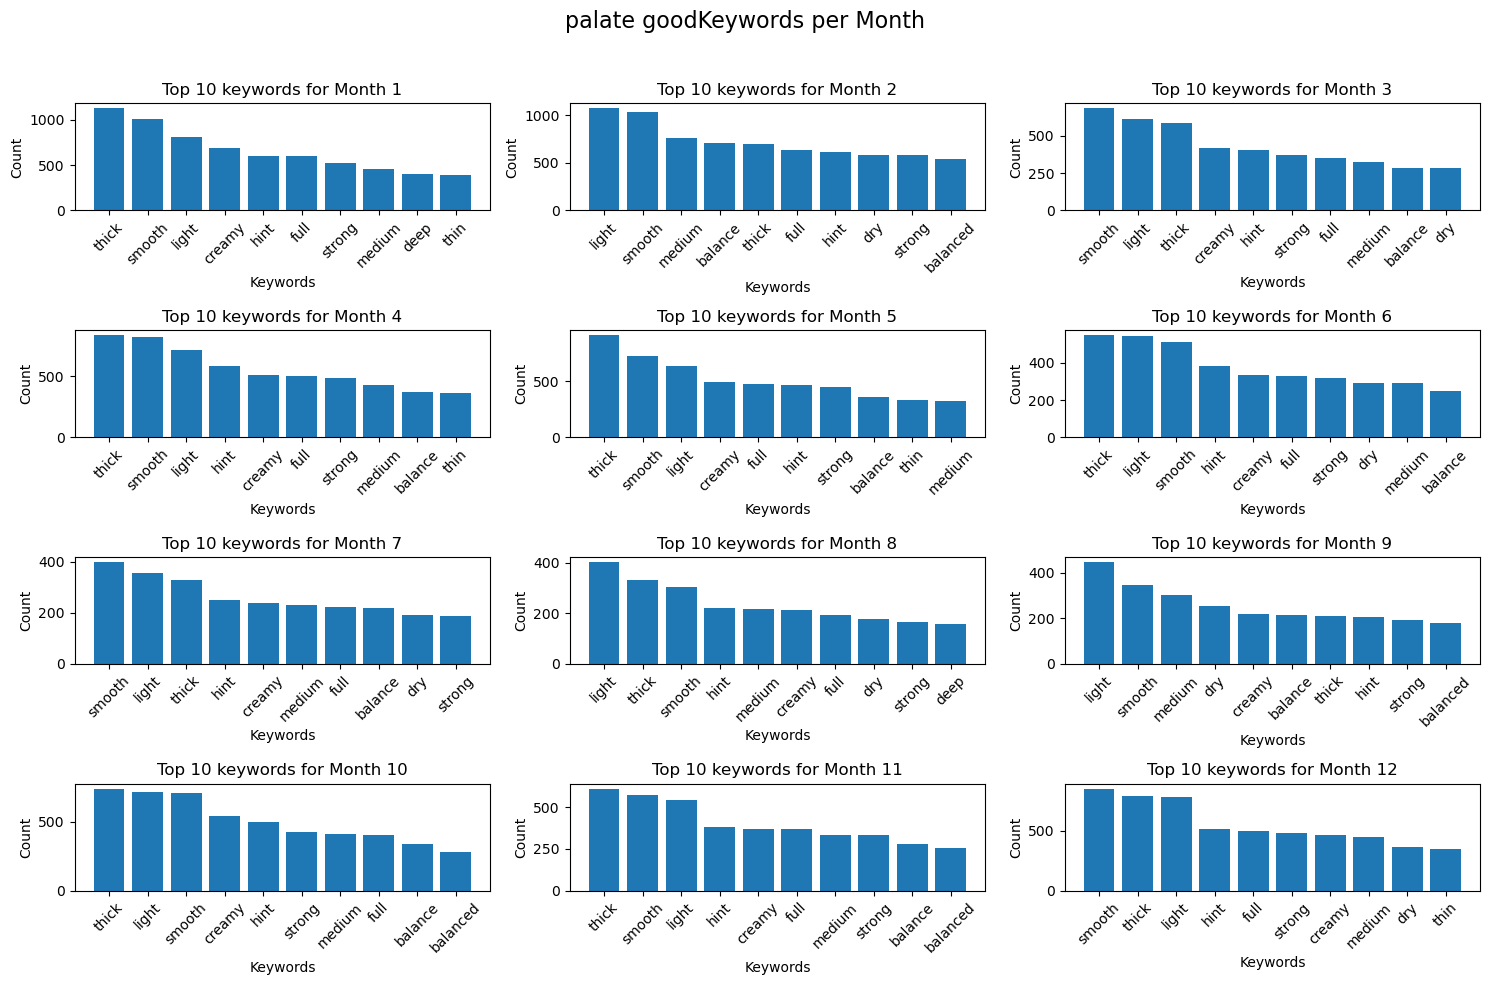

In [61]:
plot_keywords(top_keywords_by_month_palate, 'palate')

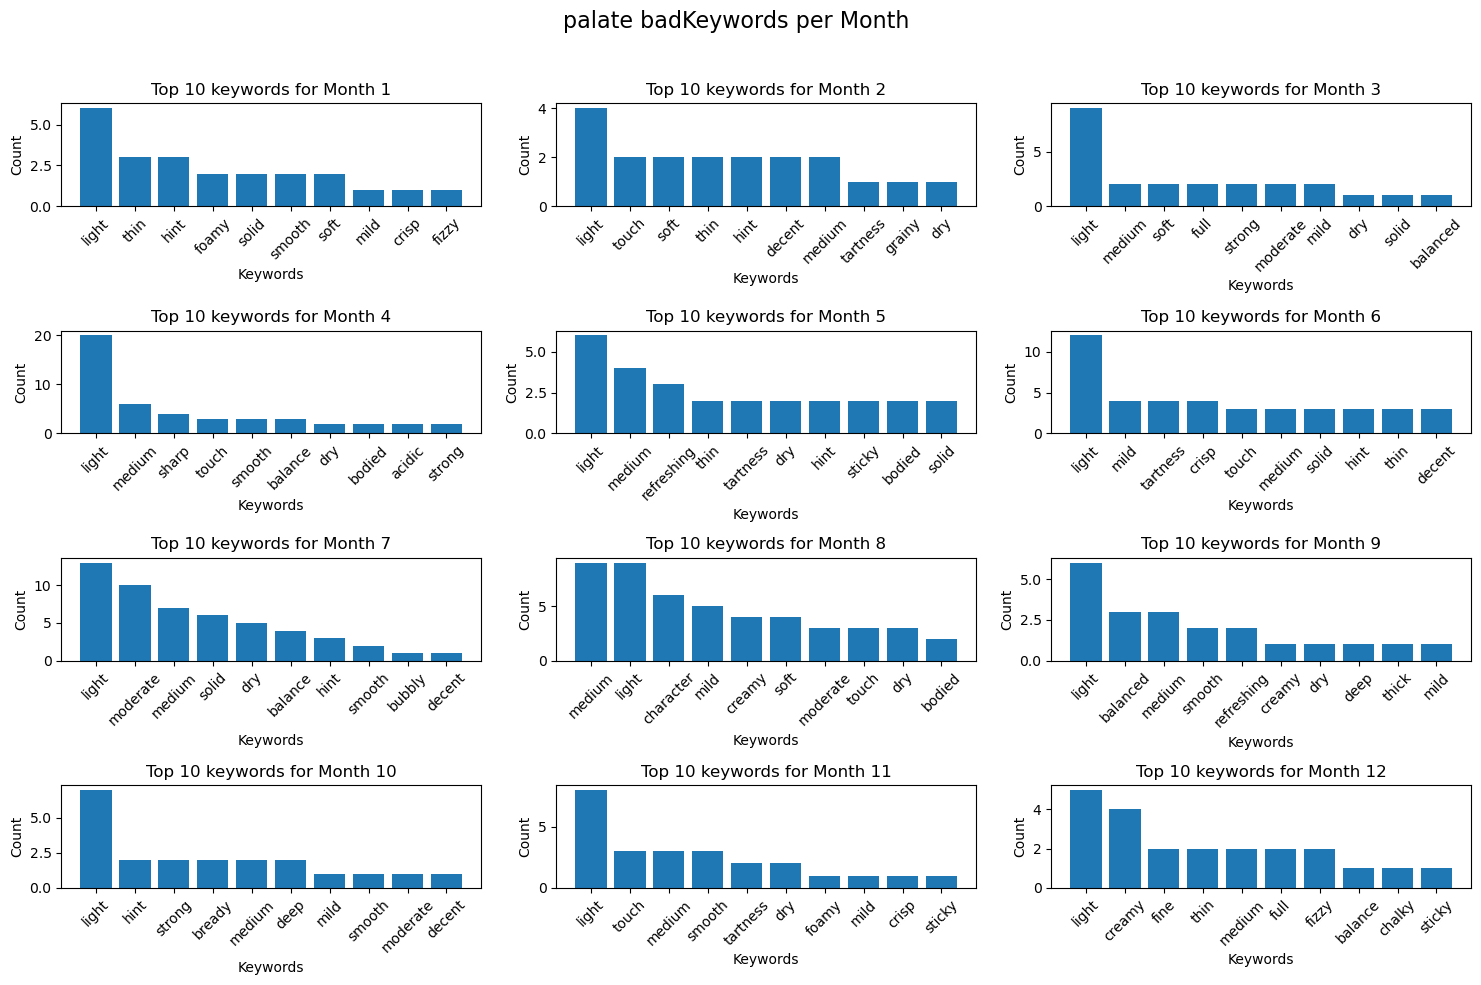

In [62]:
plot_keywords(bad_top_keywords_by_month_palate, 'palate', True)

## Appearance analysis

In [53]:
# for each month, find the top 10 keywords
top_keywords_by_month_appearance = {}
bad_top_keywords_by_month_appearance = {}

for month in range(1, 13):
    top_keywords_by_month_appearance[month] = find_top_keywords_by_month(good_ratings_combined_df, appearance_terms, month, 'appearance', 10)
    bad_top_keywords_by_month_appearance[month] = find_top_keywords_by_month(good_ratings_combined_df, appearance_terms, month, 'appearance', 10, bad=True)
    
    #print("Month", month)
    #print(top_keywords_by_month_appearance[month])
    #print()

       beer_id  appearance  count  above_average  below_average  lower_bound
10613    34420    4.619601    301            299              2     0.976101
5332     12013    4.466049    162            161              1     0.965867
328        412    4.454096    354            347              7     0.959752
11834    40149    4.460938    160            158              2     0.955575
599        752    4.433099     71             71              0     0.948672
4070      7971    4.482609    345            335             10     0.947474
578        731    4.487903    186            182              4     0.946019
12445    42723    4.477778     90             89              1     0.939716
48          61    4.310870    115            113              2     0.938800
10329    33127    4.576705     88             87              1     0.938405
       beer_id  appearance  count  above_average  below_average  lower_bound
54984   377608        3.00      1              0              1          0.0

       beer_id  appearance  count  above_average  below_average  lower_bound
874       1160    4.453598    264            260              4     0.961697
10627    34420    4.573684     95             95              0     0.961135
4113      7971    4.499094    276            270              6     0.953392
13529    47022    4.570513     78             78              0     0.953062
148        197    4.452381     63             63              0     0.942529
11604    38334    4.426230     61             61              0     0.940756
12463    42723    4.486842     57             57              0     0.936861
7714     20931    4.366071     56             56              0     0.935806
5392     11757    4.468045    134            130              3     0.935782
10640    34483    4.446970    132            129              3     0.935311
       beer_id  appearance  count  above_average  below_average  lower_bound
33780   153575         3.0      1              0              1          0.0

       beer_id  appearance  count  above_average  below_average  lower_bound
9745     33127    4.604885    177            173              1     0.968169
10115    34420    4.606928    174            165              1     0.966671
10126    34483    4.537736    222            209              3     0.959228
13002    47658    4.546296     81             81              0     0.954722
8186     25082    4.519084    131            129              2     0.946044
70          92    4.333333    195            182              4     0.946019
320        412    4.427390    283            264              8     0.943047
4024      7971    4.438447    285            256              8     0.941354
16311    63152    4.389535     86             85              1     0.937036
7595     21822    4.361607     57             56              0     0.935806
       beer_id  appearance  count  above_average  below_average  lower_bound
22001    90601         3.0      1              0              1          0.0

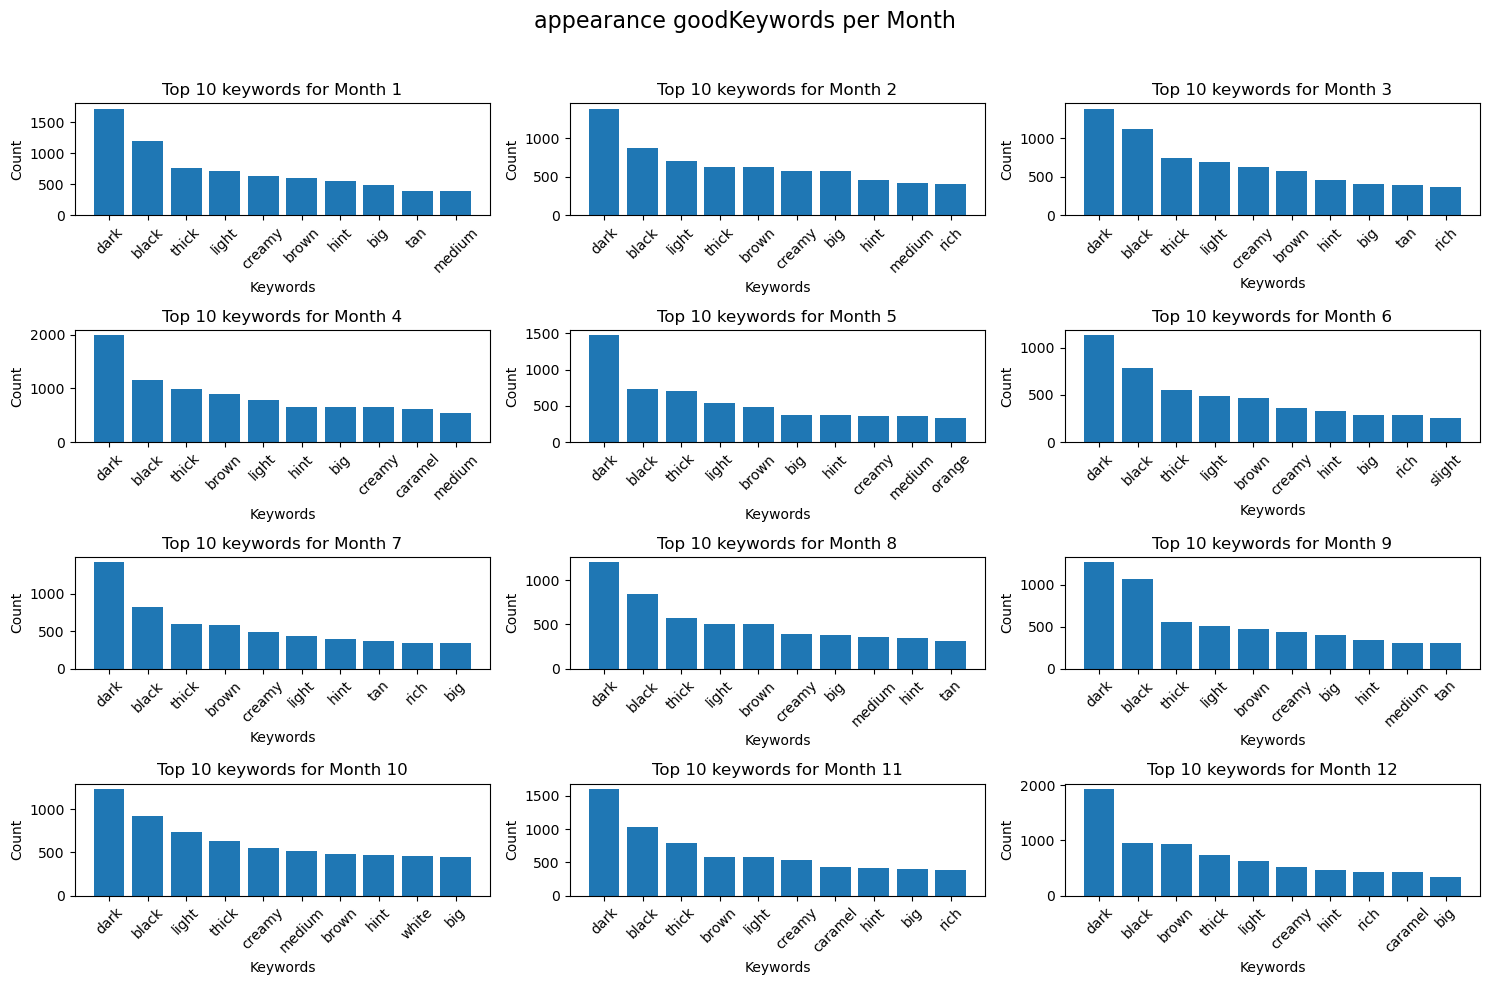

In [63]:
plot_keywords(top_keywords_by_month_appearance, 'appearance')

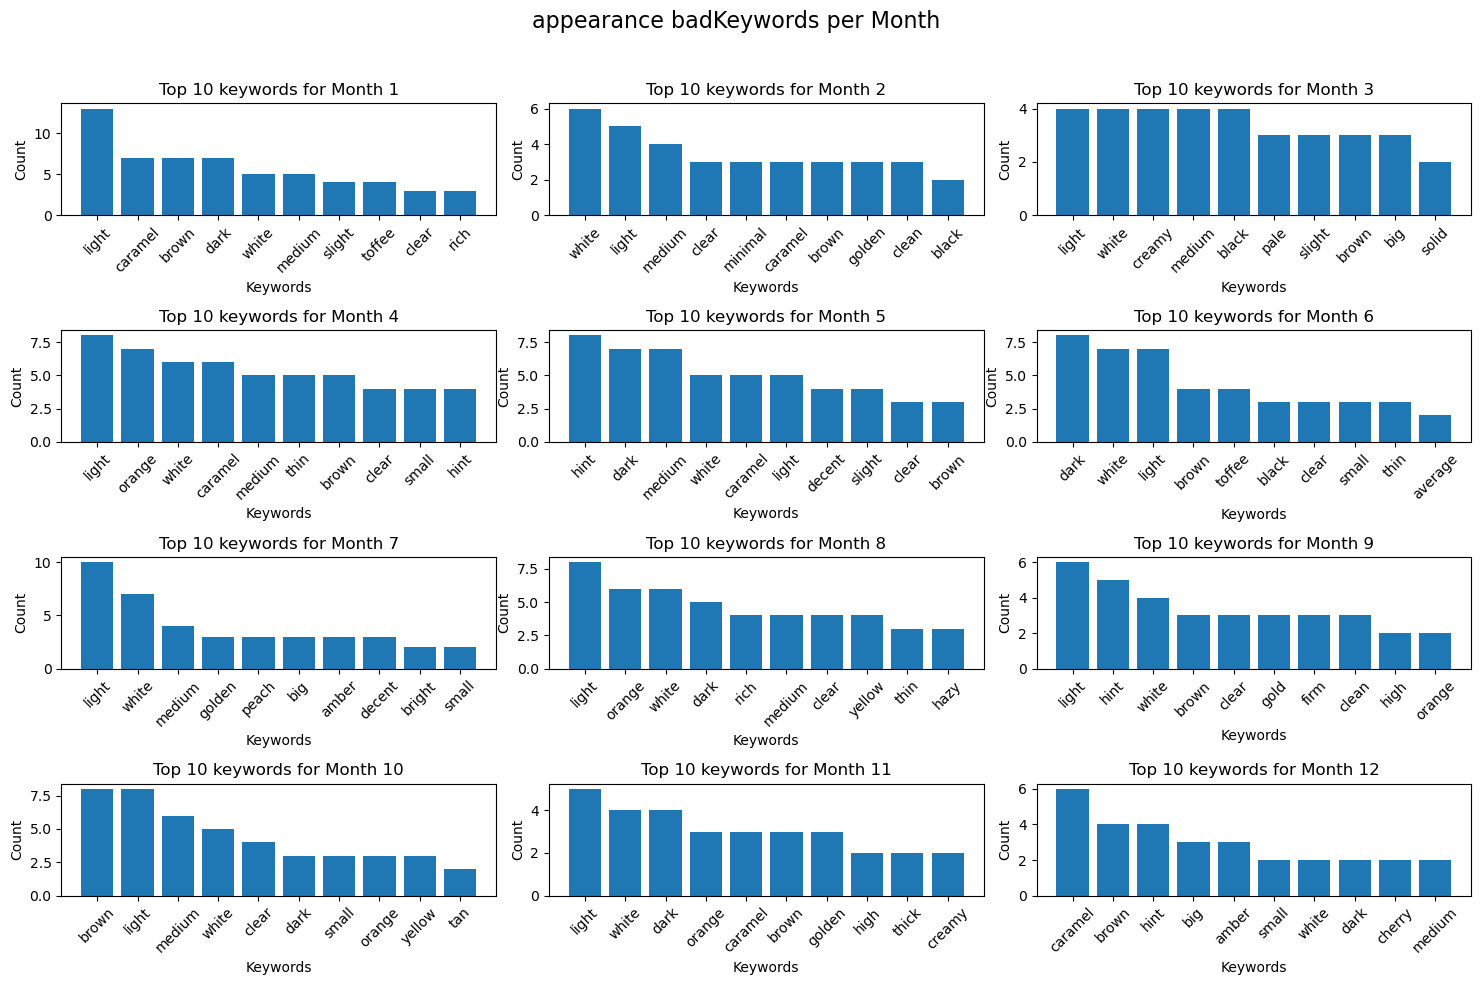

In [65]:
plot_keywords(bad_top_keywords_by_month_appearance, 'appearance', True)

As we see, some keywords are used for the good and for the bad ratings as well. However, there occur much more often for the good description than for the bad ones. This makes sens since users have different appreciation for the same beer carachteristic. For example, someone might love "dark" beer wheras someone else might hate it but the beer will be described as "dark" in both the good and the bad ratings. However, as the occurence is much more important in the good ratings, we can safely use them to describe our best beers.